In [14]:
import numpy as np
import pandas as pd
import os

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')

# Defining Contrastive loss and other utils

In [15]:
import random
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

# Loading preprocessed dataset

In [16]:
ds = pd.read_csv("./darknet_dataset_processed.csv", keep_default_na = False, low_memory = False, error_bad_lines = False)
pd.set_option('mode.chained_assignment',  None)
data = ds[['Total Fwd Packet', 'Total Bwd packets', 'Protocol', 'Src Port', 'Dst Port', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'dst_bogon', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
      'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'Average Packet Size', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg', 'Down/Up Ratio', 'Bwd Bytes/Bulk Avg', 'Bwd Packet/Bulk Avg', 'Bwd Bulk Rate Avg',
       'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'FWD Init Win Bytes', 'Bwd Init Win Bytes',
       'Fwd Act Data Pkts', 'Fwd Seg Size Min']]
scaler = StandardScaler()
data_std = scaler.fit_transform(data)
data.fillna(data.mean(), inplace=True)
data_std = pd.DataFrame(data_std, columns=data.columns)

<ipython-input-16-28a9d526590b>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  ds = pd.read_csv("./darknet_dataset_processed.csv", keep_default_na = False, low_memory = False, error_bad_lines = False)


In [17]:
train_x = data.values.reshape(data.values.shape[0], 8, 8)

# Resize 8x8 data to 32x32 by repeating values.
def resize_by_repetition(data_8x8):
    n_samples = data_8x8.shape[0]
    data_32x32 = np.zeros((n_samples, 32, 32))

    for i in range(8):
        for j in range(8):
            data_32x32[:, i*4:i*4+4, j*4:j*4+4] = data_8x8[:, i:i+1, j:j+1]

    return data_32x32

x_resize = resize_by_repetition(train_x)

In [18]:
train_data = np.array(x_resize).reshape(-1,32,32)
label_encoder = LabelEncoder()
train_labels = np.array(label_encoder.fit_transform(ds['Label']))

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, shuffle=True, random_state=1)
print("Train data shape: {}.".format(x_train.shape))
num_classes =2

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)
digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

Train data shape: (75760, 32, 32).


# Model instantiation and training

In [19]:
num_classes = 2
epochs = 10

input_shape = (32, 32)
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=64,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

y_pred_tr = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred_tr)
y_pred_te = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred_te)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

Epoch 1/10
71/71 [==============================] - 2s 11ms/step - loss: 0.1939 - accuracy: 0.7191 - val_loss: 0.1697 - val_accuracy: 0.7529
Epoch 2/10
71/71 [==============================] - 1s 10ms/step - loss: 0.1660 - accuracy: 0.7703 - val_loss: 0.1409 - val_accuracy: 0.8232
Epoch 3/10
71/71 [==============================] - 1s 13ms/step - loss: 0.1553 - accuracy: 0.7844 - val_loss: 0.1292 - val_accuracy: 0.8280
Epoch 4/10
71/71 [==============================] - 1s 17ms/step - loss: 0.1482 - accuracy: 0.7904 - val_loss: 0.1645 - val_accuracy: 0.7553
Epoch 5/10
71/71 [==============================] - 1s 17ms/step - loss: 0.1421 - accuracy: 0.7994 - val_loss: 0.1265 - val_accuracy: 0.8264
Epoch 6/10
71/71 [==============================] - 2s 22ms/step - loss: 0.1352 - accuracy: 0.8109 - val_loss: 0.1199 - val_accuracy: 0.8480
Epoch 7/10
71/71 [==============================] - 1s 15ms/step - loss: 0.1303 - accuracy: 0.8202 - val_loss: 0.1312 - val_accuracy: 0.8328
Epoch 8/10
71

# Evaluation

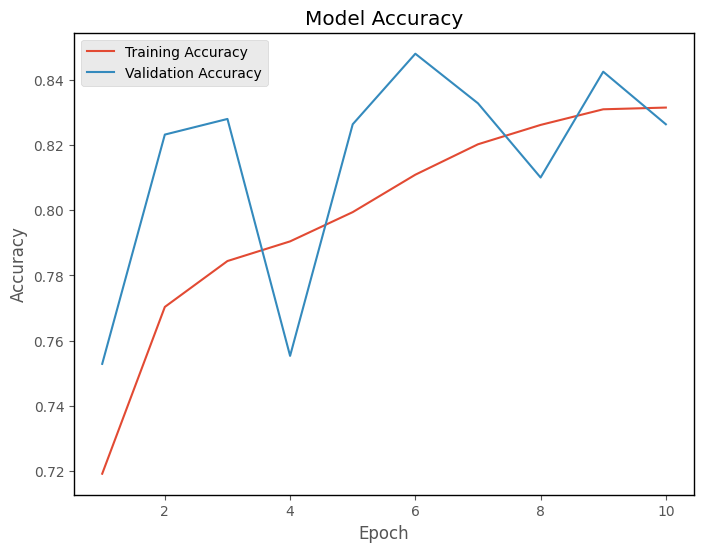

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 6))
plt.gca().set_facecolor('white')
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()
